# Fight_Detection_From_Surveillance_Cameras-PyTorch_Project

In [ ]:
from google.colab import drive
drive._mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Load the Project Repo from Github
%%capture
! git clone https://github.com/MohamedSebaie/Fight_Detection_From_Surveillance_Cameras-PyTorch_Project

In [ ]:
# Discard the output of this cell.
%%capture
# Install the required libraries.
!pip install pafy youtube-dl moviepy
!pip install pytube

In [ ]:
%%capture
import random
import time
import math
import numpy as np
import torch
import os
import cv2
import torchvision
from moviepy.editor import *
from collections import deque

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [ ]:
cd /content/Fight_Detection_From_Surveillance_Cameras-PyTorch_Project/UtilsFiles

/content/Fight_Detection_From_Surveillance_Cameras-PyTorch_Project


In [ ]:
import Fight_utils
from Fight_utils import *

In [ ]:
DATASET_DIR = '/content/Fight_Detection_From_Surveillance_Cameras-PyTorch_Project/Dataset'
CLASSES_LIST = ['fight','noFight']
SEQUENCE_LENGTH = 16
batch_size= 4

# FineTuninng and Training

In [ ]:
%%capture
seed_constant = 70
np.random.seed(seed_constant)
random.seed(seed_constant)
torch.manual_seed(seed_constant)
torch.cuda.manual_seed_all(seed_constant)

In [ ]:
model_ft = torchvision.models.video.r2plus1d_18(pretrained=True, progress=True)

Downloading: "https://download.pytorch.org/models/r2plus1d_18-91a641e6.pth" to /root/.cache/torch/hub/checkpoints/r2plus1d_18-91a641e6.pth


  0%|          | 0.00/120M [00:00<?, ?B/s]

In [ ]:
num_ftrs = model_ft.fc.in_features   #in_features
model_ft.fc = torch.nn.Linear(num_ftrs, 2) #nn.Linear(in_features, out_features)

In [ ]:
x_tensor, y_tensor=Fight_utils.create_dataset(DATASET_DIR,CLASSES_LIST,SEQUENCE_LENGTH)

Extracting Data of Class: fight
Extracting Data of Class: noFight


In [ ]:
x_tensor.shape

torch.Size([300, 3, 16, 112, 112])

In [ ]:
x_tensor, y_tensor = x_tensor.to(device), y_tensor.to(device)

In [ ]:
dataset = torch.utils.data.TensorDataset(x_tensor, y_tensor)
val_size = int(len(dataset)*0.3)
train_size = len(dataset)- int(len(dataset)*0.3)
train_dataset, test_val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

In [ ]:
val_size = int(len(test_val_dataset)*0.5)
test_size = len(test_val_dataset)- int(len(test_val_dataset)*0.5)
val_dataset, test_dataset = torch.utils.data.random_split(test_val_dataset, [val_size, test_size])

In [ ]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
dataloaders_dict = {'train':train_loader,'val':val_loader }

In [ ]:
# To empty the Memory
torch.cuda.empty_cache()

In [ ]:
# Send the model to GPU
model_ft = model_ft.to(device)

# No of Epochs
epochs = 30

# Loss Function
criterion = torch.nn.CrossEntropyLoss()

# Optimization Function (SGD-----> Stocastic Gradient Descent)
optimizer_ft = torch.optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

In [ ]:
# Train and evaluate
model_ft, hist = Fight_utils.train_model(device,model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=epochs)

Epoch 0/29
----------
train Loss: 0.6863 Acc: 0.6143
val Loss: 0.5424 Acc: 0.6444

Epoch 1/29
----------
train Loss: 0.5675 Acc: 0.7190
val Loss: 0.3053 Acc: 0.8667

Epoch 2/29
----------
train Loss: 0.3378 Acc: 0.8667
val Loss: 0.3344 Acc: 0.8889

Epoch 3/29
----------
train Loss: 0.4324 Acc: 0.8476
val Loss: 0.3184 Acc: 0.8667

Epoch 4/29
----------
train Loss: 0.4694 Acc: 0.8238
val Loss: 0.3480 Acc: 0.8667

Epoch 5/29
----------
train Loss: 0.2858 Acc: 0.8857
val Loss: 0.5155 Acc: 0.8222

Epoch 6/29
----------
train Loss: 0.2248 Acc: 0.9286
val Loss: 0.5998 Acc: 0.8000

Epoch 7/29
----------
train Loss: 0.1387 Acc: 0.9476
val Loss: 0.3467 Acc: 0.8667

Epoch 8/29
----------
train Loss: 0.3268 Acc: 0.8905
val Loss: 0.5603 Acc: 0.8444

Epoch 9/29
----------
train Loss: 0.1951 Acc: 0.9381
val Loss: 0.4016 Acc: 0.8889

Epoch 10/29
----------
train Loss: 0.2122 Acc: 0.9000
val Loss: 0.4281 Acc: 0.8667

Epoch 11/29
----------
train Loss: 0.2384 Acc: 0.9095
val Loss: 0.4159 Acc: 0.8444

Ep

In [ ]:
since = time.time()
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True)
model_ft.eval()
running_loss = 0.0
running_corrects = 0
y_test = []
y_pred = []
for inputs, labels in test_loader:
  inputs = inputs.to(device)
  labels = labels.to(device)
  optimizer_ft.zero_grad()
  with torch.set_grad_enabled(False):
    outputs = model_ft(inputs)
    loss = criterion(outputs, labels)
    _, preds = torch.max(outputs, 1)
  running_loss += loss.item() * inputs.size(0)
  running_corrects += torch.sum(preds == labels.data)
  y_test += labels.data.tolist()
  y_pred += preds.data.tolist()

epoch_loss = running_loss / len(test_loader.dataset)
epoch_acc = running_corrects.double() / len(test_loader.dataset)
time_elapsed = time.time() - since
print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
print('Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss, epoch_acc))

Training complete in 0m 4s
Loss: 0.4137 Acc: 0.8222


In [ ]:
from sklearn.metrics import confusion_matrix
#Generate the confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)
print(cf_matrix)

[[16  6]
 [ 2 21]]


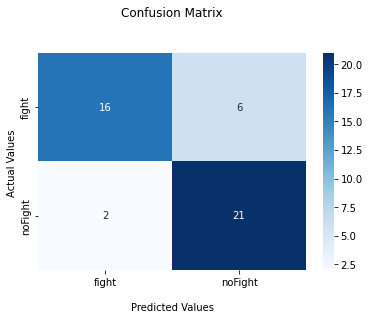

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')
ax.set_title('Confusion Matrix\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');
## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['fight','noFight'])
ax.yaxis.set_ticklabels(['fight','noFight'])
## Display the visualization of the Confusion Matrix.
plt.show()

# Save and Load the Model

In [ ]:
# # To Save the Model
# PATH="/content/drive/MyDrive/Fight_Detection_Project/First_Run_State70_Seq16_Batch8/model_16_70_8_0.8667.pth"
# torch.save(model_ft.state_dict(), PATH)

In [ ]:
# Later to Load the Saved Model:
%%capture
PATH="/content/drive/MyDrive/Fight_Detection_Project/First_Run_State70_Seq16_Batch4/model_16_70_4_0.88.pth"
model_ft = torchvision.models.video.r2plus1d_18(pretrained=True, progress=True)
num_ftrs = model_ft.fc.in_features   #in_features
model_ft.fc = torch.nn.Linear(num_ftrs, 2) #nn.Linear(in_features, out_features)
model_ft.load_state_dict(torch.load(PATH))
model_ft.to(device)
model_ft.eval()

# Predict

In [ ]:
%%capture
# Download Videos From Youtube for Testing
Fight_utils.downloadYouTube("https://www.youtube.com/watch?v=dxOpYEFf9zs&ab_channel=PluggingDaily", "/content/")
Fight_utils.downloadYouTube("https://www.youtube.com/watch?v=rEiEJT6B7Yo&ab_channel=TelegramVideo","/content/")

# Rename the Videos
!mv "/content/CRAZY FIGHT INSIDE OF CHINESE RESTAURANT 2020.mp4" "/content/test1.mp4"
!mv "/content/Fight outside Dubai Restaurant and Lounge.mp4" "/content/test2.mp4"

In [ ]:
# Extract video frames of it (noFight Video)
%%capture
!y | ffmpeg -ss 00:00:00 -i /content/test1.mp4 -t 00:00:10 -c copy /content/out1.mp4

# Extract video frames of it (Fight Video)
!y | ffmpeg -ss 00:02:28 -i /content/test1.mp4 -t 00:00:10 -c copy /content/out2.mp4

# Extract video frames of it (Fight & noFight Video)
!y | ffmpeg -ss 00:01:28 -i /content/test1.mp4 -t 00:02:28 -c copy /content/out3.mp4

# Extract video frames of it (Fight & noFight Video)
!y | ffmpeg -ss 00:01:10 -i /content/test2.mp4 -t 00:00:50 -c copy /content/out4.mp4

In [ ]:
# output video (noFight Video)
path_output = "/content/out1.mp4"
Fight_utils.show_video(path_output, width=960)

In [ ]:
# output video (Fight Video)
path_output = "/content/out2.mp4"
Fight_utils.show_video(path_output, width=960)


In [ ]:
# output video (fight & noFight Video)
path_output = "/content/out3.mp4"
Fight_utils.show_video(path_output, width=960)

In [ ]:
# output video (fight & noFight Video)
path_output = "/content/out4.mp4"
Fight_utils.show_video(path_output, width=960)

In [ ]:
video_file_path1="/content/out1.mp4"
video_file_path2="/content/out2.mp4"
video_file_path3="/content/out3.mp4"
video_file_path4="/content/out4.mp4"
SEQUENCE_LENGTH=16

In [ ]:
print(Fight_utils.FightInference(video_file_path1,CLASSES_LIST,model_ft,device,SEQUENCE_LENGTH))
print(Fight_utils.FightInference_Time(video_file_path1,CLASSES_LIST,model_ft,device,SEQUENCE_LENGTH))

noFight
[('noFight', 0.94467), ('fight', 0.05533)]
***********
time is: 0.9961555004119873
noFight


In [ ]:
print(Fight_utils.FightInference(video_file_path2,CLASSES_LIST,model_ft,device,SEQUENCE_LENGTH))
print(Fight_utils.FightInference_Time(video_file_path2,CLASSES_LIST,model_ft,device,SEQUENCE_LENGTH))

fight
[('fight', 1.0), ('noFight', 0.0)]
***********
time is: 1.4432260990142822
fight


In [ ]:
print(Fight_utils.FightInference(video_file_path3,CLASSES_LIST,model_ft,device,SEQUENCE_LENGTH))
print(Fight_utils.FightInference_Time(video_file_path3,CLASSES_LIST,model_ft,device,SEQUENCE_LENGTH))

fight
[('fight', 1.0), ('noFight', 0.0)]
***********
time is: 1.2459924221038818
fight


In [ ]:
print(Fight_utils.FightInference(video_file_path4,CLASSES_LIST,model_ft,device,SEQUENCE_LENGTH))
print(Fight_utils.FightInference_Time(video_file_path4,CLASSES_LIST,model_ft,device,SEQUENCE_LENGTH))

fight
[('fight', 0.99943), ('noFight', 0.00057)]
***********
time is: 4.212649822235107
fight


__________________________________________________________________________

# Inference on Video Stream

## noFight Video

In [ ]:
start_time = time.time()
outVideo_1=Fight_utils.showIference(1,CLASSES_LIST,model_ft,device,32,2)
elapsed = time.time() - start_time
print("time is:",elapsed)

In [ ]:
VideoFileClip(outVideo_1, audio=False, target_resolution=(300,None)).ipython_display()

## Fight Video

In [ ]:
start_time = time.time()
outVideo_2=Fight_utils.showIference(2,CLASSES_LIST,model_ft,device,16,2)
elapsed = time.time() - start_time
print("time is:",elapsed)

In [ ]:
VideoFileClip(outVideo_2, audio=False, target_resolution=(300,None)).ipython_display()

## Video Contains Fight and noFight Video with `Seq 16`

In [ ]:
start_time = time.time()
outVideo_3=Fight_utils.showIference(3,CLASSES_LIST,model_ft,device,16,2)
elapsed = time.time() - start_time
print("time is:",elapsed)

## Video Contains Fight and noFight Video with `Seq 16`

In [ ]:
start_time = time.time()
outVideo_4=Fight_utils.showIference(4,CLASSES_LIST,model_ft,device,16,2)
elapsed = time.time() - start_time
print("time is:",elapsed)

In [ ]:
VideoFileClip(outVideo_4, audio=False, target_resolution=(300,None)).ipython_display()

## Save Videos to Drive

In [ ]:
# Save Video to Drive
!cp '/content/inferOut_1_16.mp4' "/content/drive/MyDrive/Fight_Detection_Project/"
!cp '/content/inferOut_2_16.mp4' "/content/drive/MyDrive/Fight_Detection_Project/"
!cp '/content/inferOut_3_16.mp4' "/content/drive/MyDrive/Fight_Detection_Project/"
!cp '/content/inferOut_4_16.mp4' "/content/drive/MyDrive/Fight_Detection_Project/"

________________________________________________________________